<a href="https://colab.research.google.com/github/Shadabur-Rahaman/30-days-ml-projects/blob/main/Day_27_Reinforcement_Learning_CartPole/notebooks/Day_27_Reinforcement_Learning_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning: CartPole Problem
## Day 27/30 of Machine Learning Project

**Project Goal**: Implement a DQN agent to solve OpenAI Gym's CartPole environment
**Key Features**:
- Experience replay memory
- Target network for stable training
- Epsilon-greedy exploration
- Model checkpointing
- Performance visualization

## 1. Import Required Libraries

In [2]:
!pip install gym[classic_control] tensorflow pyglet==1.5.27 -q\n
!pip install pygame -q\n
!apt-get install -y python3-opengl > /dev/null\n
!pip install pyvirtualdisplay > /dev/null\n
!apt-get install xvfb -y > /dev/null
import gym
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import json
import base64
from IPython.display import HTML

# Setup virtual display for rendering
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -n

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -n


## 2. Environment Setup

In [3]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(f"State size: {state_size}, Action size: {action_size}")

State size: 4, Action size: 2


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## 3. DQN Agent Implementation

In [7]:
# Fixed DQNAgent implementation
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # Discount rate
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential([
            Dense(24, input_dim=self.state_size, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        # FIXED: Use 'learning_rate' instead of 'lr'
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose=0)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)
                target[0][action] = reward + self.gamma * np.amax(t[0])
            self.model.fit(state, target, epochs=1, verbose=0)

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, name):
        self.model.save(f'rl_artifacts/{name}.h5')
        self.target_model.save(f'rl_artifacts/{name}_target.h5')
        print(f"Models saved to rl_artifacts/{name}.h5 and rl_artifacts/{name}_target.h5")

    def load(self, name):
        self.model = load_model(f'rl_artifacts/{name}.h5')
        self.target_model = load_model(f'rl_artifacts/{name}_target.h5')
        print(f"Models loaded from rl_artifacts/{name}.h5 and rl_artifacts/{name}_target.h5")

## 4. Training Configuration

In [13]:
# Training configuration with corrected agent
EPISODES = 100
BATCH_SIZE = 32
agent = DQNAgent(state_size, action_size)

# For tracking performance
episode_rewards = []
episode_epsilons = []
solved_threshold = 195  # Considered solved when avg > 195 over 100 episodes

## 5. Training Loop

In [14]:
for e in range(EPISODES):
    # Reset environment and handle new Gym API (v0.26+)
    if gym.__version__ >= '0.26.0':
        state, _ = env.reset()
    else:
        state = env.reset()

    state = np.reshape(state, [1, state_size])
    total_reward = 0

    for time in range(500):  # Max 500 steps per episode
        action = agent.act(state)

        # Handle new Gym API (v0.26+)
        if gym.__version__ >= '0.26.0':
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        else:
            next_state, reward, done, _ = env.step(action)

        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            agent.update_target_model()
            break

    # Experience replay
    if len(agent.memory) > BATCH_SIZE:
        agent.replay(BATCH_SIZE)

    agent.decay_epsilon()
    episode_rewards.append(total_reward)
    episode_epsilons.append(agent.epsilon)

    # Save model every 50 episodes
    if e % 50 == 0:
        agent.save(f'cartpole_dqn_episode_{e}')

    print(f"Episode: {e+1}/{EPISODES}, Score: {total_reward}, Epsilon: {agent.epsilon:.3f}")

# Save final model
agent.save('cartpole_dqn_final')

Models saved to rl_artifacts/cartpole_dqn_episode_0.h5 and rl_artifacts/cartpole_dqn_episode_0_target.h5
Episode: 1/100, Score: 12.0, Epsilon: 0.995
Episode: 2/100, Score: 31.0, Epsilon: 0.990
Episode: 3/100, Score: 11.0, Epsilon: 0.985
Episode: 4/100, Score: 10.0, Epsilon: 0.980
Episode: 5/100, Score: 20.0, Epsilon: 0.975
Episode: 6/100, Score: 17.0, Epsilon: 0.970
Episode: 7/100, Score: 10.0, Epsilon: 0.966
Episode: 8/100, Score: 22.0, Epsilon: 0.961
Episode: 9/100, Score: 12.0, Epsilon: 0.956
Episode: 10/100, Score: 11.0, Epsilon: 0.951
Episode: 11/100, Score: 8.0, Epsilon: 0.946
Episode: 12/100, Score: 18.0, Epsilon: 0.942
Episode: 13/100, Score: 19.0, Epsilon: 0.937
Episode: 14/100, Score: 9.0, Epsilon: 0.932
Episode: 15/100, Score: 21.0, Epsilon: 0.928
Episode: 16/100, Score: 27.0, Epsilon: 0.923
Episode: 17/100, Score: 17.0, Epsilon: 0.918
Episode: 18/100, Score: 19.0, Epsilon: 0.914
Episode: 19/100, Score: 12.0, Epsilon: 0.909
Episode: 20/100, Score: 84.0, Epsilon: 0.905
Episod

Models saved to rl_artifacts/cartpole_dqn_episode_50.h5 and rl_artifacts/cartpole_dqn_episode_50_target.h5
Episode: 51/100, Score: 20.0, Epsilon: 0.774
Episode: 52/100, Score: 39.0, Epsilon: 0.771
Episode: 53/100, Score: 25.0, Epsilon: 0.767
Episode: 54/100, Score: 13.0, Epsilon: 0.763
Episode: 55/100, Score: 18.0, Epsilon: 0.759
Episode: 56/100, Score: 13.0, Epsilon: 0.755
Episode: 57/100, Score: 28.0, Epsilon: 0.751
Episode: 58/100, Score: 9.0, Epsilon: 0.748
Episode: 59/100, Score: 11.0, Epsilon: 0.744
Episode: 60/100, Score: 30.0, Epsilon: 0.740
Episode: 61/100, Score: 16.0, Epsilon: 0.737
Episode: 62/100, Score: 14.0, Epsilon: 0.733
Episode: 63/100, Score: 9.0, Epsilon: 0.729
Episode: 64/100, Score: 19.0, Epsilon: 0.726
Episode: 65/100, Score: 36.0, Epsilon: 0.722
Episode: 66/100, Score: 14.0, Epsilon: 0.718
Episode: 67/100, Score: 28.0, Epsilon: 0.715
Episode: 68/100, Score: 17.0, Epsilon: 0.711
Episode: 69/100, Score: 17.0, Epsilon: 0.708
Episode: 70/100, Score: 10.0, Epsilon: 0

Episode: 100/100, Score: 20.0, Epsilon: 0.606
Models saved to rl_artifacts/cartpole_dqn_final.h5 and rl_artifacts/cartpole_dqn_final_target.h5


## 6. Save Training Metrics

In [15]:
# Save rewards and hyperparameters
with open('training_metrics.json', 'w') as f:
    json.dump({
        'rewards': episode_rewards,
        'epsilons': episode_epsilons,
        'hyperparameters': {
            'gamma': agent.gamma,
            'epsilon_start': 1.0,
            'epsilon_min': agent.epsilon_min,
            'epsilon_decay': agent.epsilon_decay,
            'learning_rate': agent.learning_rate
        }
    }, f)

print("Training metrics saved to training_metrics.json")

Training metrics saved to training_metrics.json


## 7. Performance Visualization

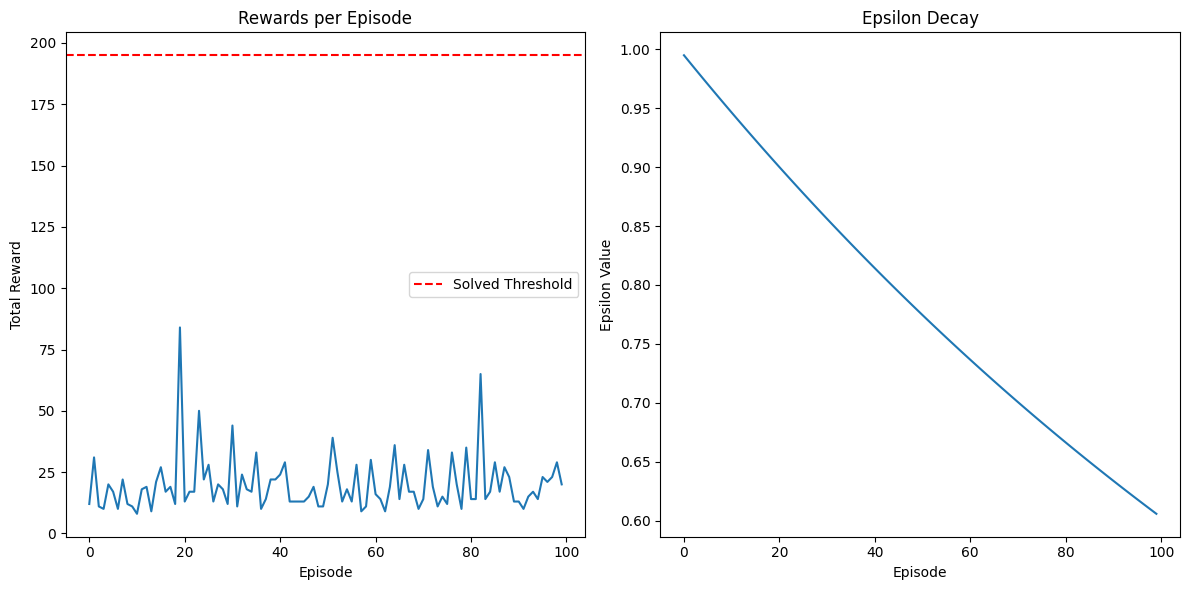

In [16]:
# Plot training progress
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.axhline(y=solved_threshold, color='r', linestyle='--', label='Solved Threshold')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(episode_epsilons)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')

plt.tight_layout()
plt.savefig('training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Evaluation and Rendering

In [28]:
import os
import base64
import numpy as np
from IPython.display import HTML
import gym
from tensorflow.keras.losses import MSE as mean_squared_error
from tensorflow.keras.models import load_model

# Workaround for bool8 issue
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# Load best model with custom objects
try:
    agent.load('cartpole_dqn_final')
except Exception as e:
    print(f"Standard load failed: {str(e)}")
    print("Trying with custom objects...")
    try:
        # Load manually with custom objects
        agent.model = load_model('rl_artifacts/cartpole_dqn_final.h5',
                                custom_objects={'mse': mean_squared_error})
        agent.target_model = load_model('rl_artifacts/cartpole_dqn_final_target.h5',
                                      custom_objects={'mse': mean_squared_error})
        print("Models loaded successfully with custom objects")
    except Exception as e2:
        print(f"Failed to load models: {str(e2)}")
        print("Creating new agent as fallback")
        agent = DQNAgent(state_size, action_size)

# Alternative video recording without RecordVideo
video_frames = []
total_reward = 0
eval_env = gym.make('CartPole-v1', render_mode='rgb_array')

# Handle different Gym API versions
if gym.__version__ >= '0.26.0':
    reset_result = eval_env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
else:
    state = eval_env.reset()

state = np.reshape(state, [1, state_size])

for t in range(500):
    # Capture frame before action
    frame = eval_env.render()
    # Ensure frame is a numpy array and remove extra dimension if present
    if isinstance(frame, list):
        frame = frame[0]  # Extract the first element if it's a list
    if isinstance(frame, np.ndarray) and len(frame.shape) == 4 and frame.shape[0] == 1:
        frame = frame.squeeze(0)
    video_frames.append(frame)

    action = np.argmax(agent.model.predict(state, verbose=0)[0])

    # Handle API differences
    if gym.__version__ >= '0.26.0':
        step_result = eval_env.step(action)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = step_result
    else:
        step_result = eval_env.step(action)
        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
        else:
            next_state, reward, done = step_result

    state = np.reshape(next_state, [1, state_size])
    total_reward += reward

    if done:
        # Capture final frame
        frame = eval_env.render()
        if isinstance(frame, list):
            frame = frame[0]  # Extract the first element if it's a list
        if isinstance(frame, np.ndarray) and len(frame.shape) == 4 and frame.shape[0] == 1:
            frame = frame.squeeze(0)
        video_frames.append(frame)
        break

eval_env.close()
print(f"Evaluation Score: {total_reward}")

# Save video manually if frames captured
if video_frames:
    try:
        from matplotlib import animation
        import matplotlib.pyplot as plt

        # Create video directory
        video_dir = 'rl_artifacts/videos'
        os.makedirs(video_dir, exist_ok=True)
        video_path = f'{video_dir}/cartpole_agent.mp4'

        # Create animation
        fig = plt.figure(figsize=(6, 4))
        plt.axis('off')
        im = plt.imshow(video_frames[0])

        def update(frame):
            im.set_array(frame)
            return [im]

        anim = animation.FuncAnimation(fig, update, frames=video_frames,
                                      interval=50, blit=True)
        anim.save(video_path, writer='ffmpeg', fps=30)
        plt.close()

        print(f"Video saved to {video_path}")

        # Display video
        mp4 = open(video_path, 'rb').read()
        data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
        HTML(f"""
        <video width=400 controls>
              <source src="{data_url}" type="video/mp4">
        </video>
        """)
    except Exception as e:
        print(f"Couldn't create video: {str(e)}")
        print("Showing last frame instead")
        plt.figure(figsize=(6, 4))
        plt.imshow(video_frames[-1])
        plt.axis('off')
        plt.show()
else:
    print("No frames captured for video")

Standard load failed: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
Trying with custom objects...
Models loaded successfully with custom objects
Evaluation Score: 10.0
Video saved to rl_artifacts/videos/cartpole_agent.mp4


## 9. Model Architecture Summary

In [29]:
with open('model_summary.txt', 'w') as f:
    agent.model.summary(print_fn=lambda x: f.write(x + '\n'))

print("Model summary saved to model_summary.txt")
agent.model.summary()

Model summary saved to model_summary.txt


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 24)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 772 (3.02 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)